<a href="https://colab.research.google.com/github/doeungim/ADP_DE/blob/main/ADP_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#pca
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#t-test
from scipy.stats import ttest_ind


#modeling
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


import warnings
warnings.filterwarnings('ignore')


from imblearn.over_sampling import SMOTE
import xgboost as xgb
import scipy.stats as stats
import math
from scipy.stats import chi2_contingency
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv',encoding= 'cp949')


 계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라.

In [ ]:
df1 = df.sort_values(['계약자고유번호','거주연도'])
df1 = df1.drop_duplicates('계약자고유번호', keep = "last").reset_index(drop = True)

1-2 결측치 처리

In [ ]:
display(df1.isnull().sum())


순번            0
계약구분         61
재계약횟수         0
거주개월          0
아파트 이름        0
아파트 ID        0
아파트 평점      141
호실고유번호        0
층             0
평형대           0
계약자고유번호       0
계약서고유번호       0
입주연도          0
퇴거연도       6257
거주연도          0
월세(원)         0
보증금(원)        0
대표나이          0
나이            0
성별            0
결혼여부          0
거주자 수         0
퇴거여부          0
dtype: int64

In [ ]:
# r계약 구분- 유효, 해치  퇴거여부 -# 미퇴거, 퇴거
#df1['퇴거여부'].value_counts()
# 미퇴거, 퇴거
dic = {'미퇴거' : '유효', '퇴거': '해지'}
df1['계약구분'] = df1['퇴거여부'].map(dic)

In [ ]:
# 아파트별 평균 점수
display(df1.groupby(['아파트 이름'])['아파트 평점'].mean().reset_index().values)

apt_idc = {name : score for name , score in  df1.groupby(['아파트 이름'])['아파트 평점'].mean().reset_index().values}

df1['아파트 평점'] = df1['아파트 이름'].map(apt_idc)



array([['강남아파트', 7.0],
       ['까치아파트', 10.0],
       ['비둘기아파트', 5.0],
       ['용지아파트', 7.0],
       ['지산5단지아파트', 8.0]], dtype=object)

In [ ]:
## 퇴거연도 - 퇴거여부가 미퇴거이고, 계약이 유호한 경우에는 퇴거 연도가 없는것이 당연하다 - 컬럼 자체를 삭제

df2 = df1.drop(columns = '퇴거연도', axis = 1)

1-3 이상치 처리

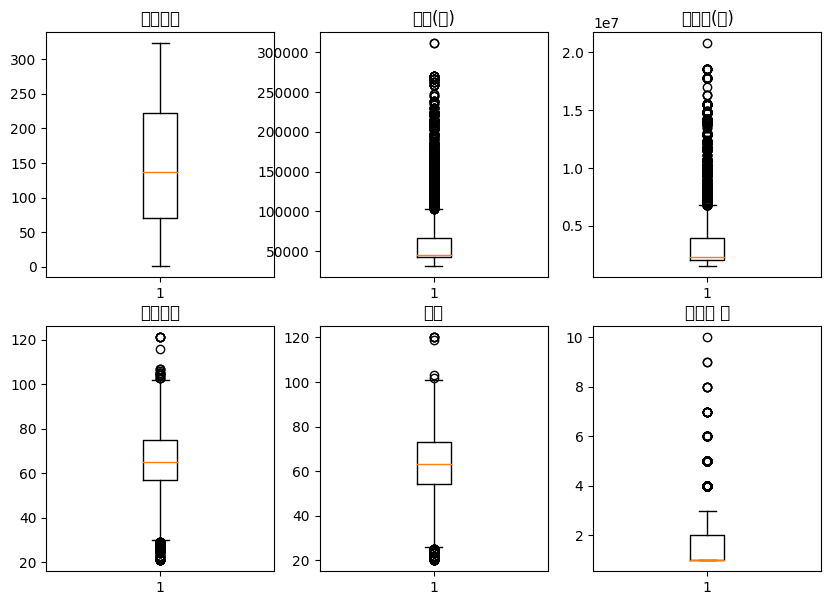

In [ ]:
df2.columns
col = ['거주개월', '월세(원)', '보증금(원)', '대표나이', '나이', '거주자 수']

fig, axes = plt.subplots(2,3, figsize = (10,7))

for i, ax in enumerate(axes.flat[:]):
  col_i = col[i]
  ax.boxplot(df2[col_i])
  ax.set_title(col_i)

  ## 나이와 대표 나이에 이상치가 존재하는 것으로 보임

In [ ]:
cols = ['대표나이','나이']

for col in cols :
  IQR = df2[col].quantile(0.75) - df2[col].quantile(0.25)
  lower = df2[col].quantile(0.25) - IQR * 1.5
  upper = df2[col].quantile(0.75) + IQR * 1.5
  df2[col] = df2[col].clip(lower, upper)


df2[col].describe()

count    10348.000000
mean        62.639399
std         14.090221
min         25.500000
25%         54.000000
50%         63.000000
75%         73.000000
max        101.500000
Name: 나이, dtype: float64

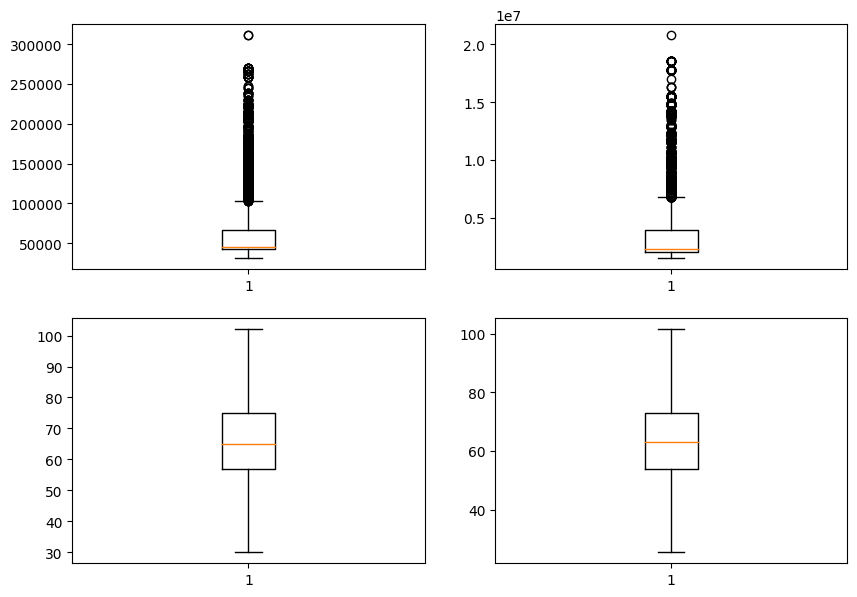

In [ ]:
df3 = df2.copy()
cols = ['월세(원)', '보증금(원)']

def remove_iqr(df):
  for col in cols :
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    up = df[col].quantile(0.75) + 1.5 * iqr
    down = df[col].quantile(0.25) - 1.5 * iqr
    df = df[(df[col] >= down) & (df[col]) <= up]

    return df.reset_index(drop= True)


## 이상치 제거 후의 box_plot
col = ['월세(원)' , '보증금(원)', '대표나이', '나이']

fig, axes = plt.subplots(2,2, figsize =(10,7))

for i, ax in enumerate(axes.flat[:]):
  col_i = col[i]
  ax.boxplot(df3[col_i])

#fig, axes = plt.subplots(2, 9, figsize=(15, 5))
#feats = [col for col in df.columns if df[col].dtypes != object]
#for ax, col in zip(axes.ravel(), feats):
#    ax.boxplot(df[col])
#    ax.set_xticklabels([col])
#plt.show()

-1 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성하df

In [ ]:
df4 = df3.copy()
m = df4['재계약횟수'].median()

df4['이분변수'] = df4['재계약횟수'].map(lambda x : '높음' if x >= m else '낮음')


2-2 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오

In [ ]:
df5 = df4.drop(columns =['순번','아파트 이름','호실고유번호','계약자고유번호','계약서고유번호','대표나이','나이','월세(원)','보증금(원)'])
cat_col = df5.select_dtypes(include = 'object').columns

dum_df = pd.get_dummies(df5[cat_col],  drop_first= True, dtype = 'int')

from sklearn.preprocessing import MinMaxScaler

num_df = df5[df5.select_dtypes(exclude = 'object').columns]
mm = MinMaxScaler()
#df_total = pd.DataFrame(mm.fit_transform(dum_df), columns = dum_df)
#df_total
total_df = pd.DataFrame(
                        mm.fit_transform(num_df), columns = num_df.columns).reset_index(drop = True)

pca_df = pd.concat([dum_df, total_df], axis = 1)

from sklearn.decomposition import PCA
pca = PCA()
pca_result  = pca.fit_transform(pca_df)

pca = pd.DataFrame(
                  {'var' : pca.explained_variance_ratio_ ,
                  'cumsum' :  pca.explained_variance_ratio_.cumsum()
                  })

pca.index = ['pc' + str(i) for i in range(len(pca.index))]
pca
#np.any(np.isnan(total_df))
#total_df.isnull().sum()



,var,cumsum
pc0,3.560025e-01,0.356003
pc1,2.055420e-01,0.561545
pc2,1.592416e-01,0.720786
pc3,7.498264e-02,0.795769
pc4,5.761396e-02,0.853383
pc5,5.437842e-02,0.907761
pc6,4.519302e-02,0.952954
pc7,2.583965e-02,0.978794
pc8,1.182962e-02,0.990623
pc9,4.655119e-03,0.995279


재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석

In [ ]:
pca_df.columns

Index(['계약구분_해지', '성별_여', '결혼여부_미혼', '퇴거여부_퇴거', '이분변수_높음', '재계약횟수', '거주개월',
       '아파트 ID', '아파트 평점', '층', '평형대', '입주연도', '거주연도', '거주자 수'],
      dtype='object')

In [ ]:
#sns.histplot(data = pca_df, x = '거주개월', hue = '이분변수_높음')

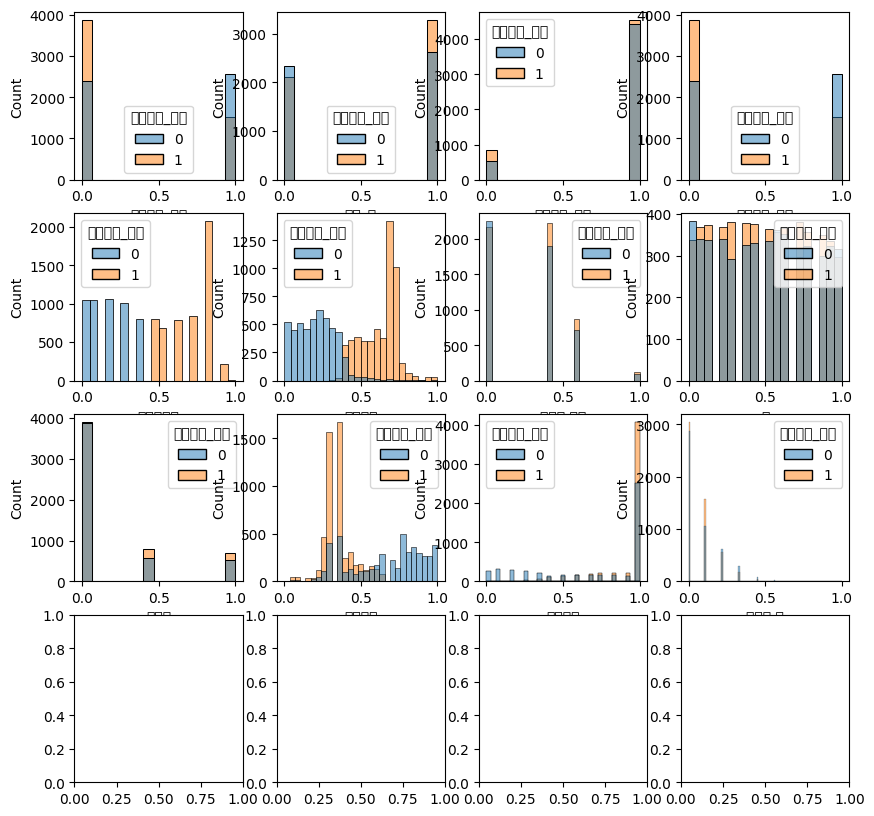

,0,1,2,3,4,5,6,7,8,9,10,11
variable,계약구분_해지,성별_여,결혼여부_미혼,퇴거여부_퇴거,재계약횟수,거주개월,아파트 평점,층,평형대,입주연도,거주연도,거주자 수
p_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.852,0.0,0.0,0.0,0.0


In [ ]:
cols = ['계약구분_해지', '성별_여', '결혼여부_미혼', '퇴거여부_퇴거', '재계약횟수', '거주개월',
       '아파트 평점', '층', '평형대', '입주연도', '거주연도', '거주자 수']

lst = []
fig, axes = plt.subplots(4,4, figsize=(10,10))

for i, col in enumerate(cols):
  #col_i = cols
  #pca_df['이분변수_높음'] =  pca_df['이분변수_높음'].map({0: 0, 1 :1})
  target = pca_df[[col, '이분변수_높음']]

  s, p = ttest_ind(target.query('이분변수_높음 == 0')[col], target.query('이분변수_높음 == 1')[col])
  lst.append([col, round(p,3)])
  t = pd.DataFrame(lst, columns = ['variable', 'p_value'])

  sns.histplot(data = pca_df, x = col, hue = '이분변수_높음', ax = axes.flat[i] )

plt.show()
t.T



3-2. 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정

In [ ]:
df6 = pca_df
df6 = df6.rename(columns = {'이분변수_높음': 'y'})

x = df6.drop(columns = ['y', '재계약횟수', '거주개월','거주연도','입주연도'])
y = df6['y']


cls_rf = RandomForestClassifier()
cls_df = DecisionTreeClassifier()

reg_rf = RandomForestRegressor()
reg_df = DecisionTreeRegressor()


def modelling(model, types, name):
  if types == 'cls':
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = accuracy_score(pred, y_test)

  elif types == 'reg' :
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state =1234)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = mean_squared_error(pred, y_test)

  return {name:acc}, model

lst = {}
model_lst = []

for models in [[cls_rf ,'cls' , 'RandomForest_Classification'],
               [cls_df ,'cls' ,'DecisionTree_Classification'],
               [reg_rf ,'reg' ,'RandomForest_Regressioon'],
               [reg_df ,'reg' , 'DecisionTree_Regression']] :

                model = models[0]
                types = models[1]
                name =  models[2]
                acc, model = modelling(model, types, name)
                lst.update(acc)
                model_lst.append(model)


display(pd.DataFrame(lst.items(), columns = ['Model_name', 'Accuracy']))


,Model_name,Accuracy
0,RandomForest_Classification,0.608374
1,DecisionTree_Classification,0.599356
2,RandomForest_Regressioon,0.253432
3,DecisionTree_Regression,0.289516


<BarContainer object of 9 artists>

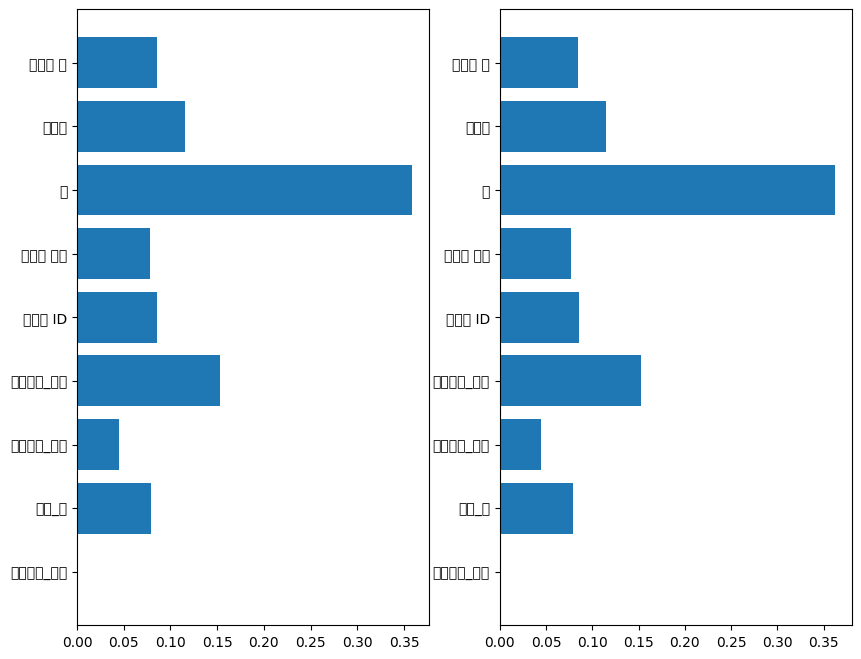

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,8))

ax[0].barh(model_lst[1].feature_names_in_, model_lst[1].feature_importances_)
ax[1].barh(model_lst[3].feature_names_in_, model_lst[3].feature_importances_)

- 첫타자와 둘째타자의 각 이닝별 출루현황, 해당 이닝의 득점수를 3columns의 데이터로 변환
- 정수형 값이 아닌 데이터 행를 제거
- 홈런 (4)값을 가지는 행을 제거
- 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
- 둘째 타자 출루 결과를 one-hot encoding

In [ ]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')

df.head(3)

,game_id,a1_1,a1_2,a2_1,a2_2,a3_1,a3_2,a4_1,a4_2,a5_1,a5_2,a6_1,a6_2,a7_1,a7_2,a8_1,a8_2,a9_1,a9_2,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,201900016,5,5,5,5,5,5,5,5,5,5,7,1,5,5,1,1,1,5,0,0,0,0,0,0,0,4,2
1,201900023,6,4,5,5,2,5,1,1,6,5,4,1,1,5,5,6,2,7,3,0,0,1,0,1,3,1,0
2,201900103,5,6,5,5,1,9,5,4,6,1,4,2,6,1,5,5,5,6,0,0,1,1,4,1,2,0,1


In [ ]:
lst = []

for i in range(1, 10) :

  x = df[['game_id', f'a{i}_1', f'a{i}_2', f'b{i}']]
  ## 1~10부터 몇 번쨰 이닝인지
  x['inning'] = i
  x.columns = ['game_id','a_1', 'a_2', 'score','inning']
  # 각 이닝을 lst 에 append
  lst.append(x)

df1 = pd.concat(lst, axis = 0).reset_index(drop = True)

# Object to numeric
df2 = df1[df1['a_1'].str.isdigit() == True]
df2['a_1'] = pd.to_numeric(df2['a_1'])


# 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
df2['score'] = df2['score'].map(lambda x : 1 if x > 0 else 0)


# 홈런값 제거 = 4
df2 = df2.loc[(df2['a_1'] != 4 ) & (df2['a_2'] != 4 )]

# 둘째 타자 출루 결과 원핫 인코딩
df3 = pd.get_dummies(df2['a_2'], dtype = 'int')
df3.columns = [str(i) + "_2nd" for i in range(len(df3.columns))]

df4 = pd.concat([df2, df3], axis = 1).drop(columns = 'a_2', axis = 1)
df4.head(5)

,game_id,a_1,score,inning,0_2nd,1_2nd,2_2nd,3_2nd,4_2nd,5_2nd,6_2nd,7_2nd
0,201900016,5,0,1,0,0,0,1,0,0,0,0
2,201900103,5,0,1,0,0,0,0,1,0,0,0
3,201900112,5,0,1,0,0,0,0,0,1,0,0
4,201900131,5,0,1,1,0,0,0,0,0,0,0
5,201900141,6,0,1,0,0,0,1,0,0,0,0


데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정

In [ ]:
X = df4.drop(columns = ['game_id','score'])
y = df4.score

import statsmodels.api as sm
lr = sm.Logit(y, X)
result = lr.fit(method = 'bfgs')
print(result.summary())

         Current function value: 0.510451
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                  score   No. Observations:                  702
Model:                          Logit   Df Residuals:                      692
Method:                           MLE   Df Model:                            9
Date:                Mon, 29 Apr 2024   Pseudo R-squ.:                  0.1848
Time:                        13:31:04   Log-Likelihood:                -358.34
converged:                      False   LL-Null:                       -439.58
Covariance Type:            nonrobust   LLR p-value:                 2.263e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
a_1           -0.2924      0.046     -6.315      0.000      -0.383      -0.2

4-3 SMOTE (random_state =0 지정)를 적용하여 data imbalance를

In [ ]:
smote = SMOTE(sampling_strategy = 'auto')
sm_x, sm_y = smote.fit_resample(X,y)

t = pd.concat([y.value_counts() , sm_y.value_counts()], axis =1)
t.columns = ['Before SMOTE', 'After SMOTE']
t

,Before SMOTE,After SMOTE
score,,
0,478,478
1,224,478


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
x_train, x_test, y_train, y_test = train_test_split(sm_x, sm_y, test_size = 0.3, random_state = 3235)

lr = LogisticRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

f1_score = f1_score(y_test, pred)
print(f1_score)

0.6983050847457628


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(sm_x, sm_y, test_size = 0.3, random_state=1,stratify= sm_y)

model = sm.Logit(y_train.reset_index(drop = True), x_train.reset_index(drop = True))

res = model.fit()
display(res.summary().tables[1])

## 분류 평가 - accuracy_score
score= accuracy_score(y_test.reset_index(drop = True), res.predict(x_test).map(lambda x : 1 if x > 0.5 else 0))

display('정확도 :', score)

         Current function value: 0.586734
         Iterations: 35


,coef,std err,z,P>|z|,[0.025,0.975]
a_1,-0.1171,0.039,-3.004,0.003,-0.193,-0.041
inning,0.1540,0.036,4.309,0.000,0.084,0.224
0_2nd,0.7031,0.307,2.291,0.022,0.102,1.305
1_2nd,1.2318,0.390,3.159,0.002,0.468,1.996
2_2nd,21.1570,2.08e+04,0.001,0.999,-4.07e+04,4.08e+04
3_2nd,-0.6025,0.227,-2.653,0.008,-1.048,-0.157
4_2nd,0.3271,0.358,0.913,0.361,-0.375,1.029
5_2nd,-1.2649,0.294,-4.310,0.000,-1.840,-0.690
6_2nd,1.3845,1.140,1.215,0.225,-0.850,3.619
7_2nd,1.7639,0.637,2.767,0.006,0.515,3.013


'정확도 :'

0.7038327526132404

XGB적용

In [ ]:
import xgboost as xgb

xgb = xgb.XGBClassifier(random_stat = 345)

xgb.fit(x_train, y_train)
x_pred = xgb.predict(x_test)

accuracy_score(y_test, x_pred)

0.7317073170731707

<BarContainer object of 10 artists>

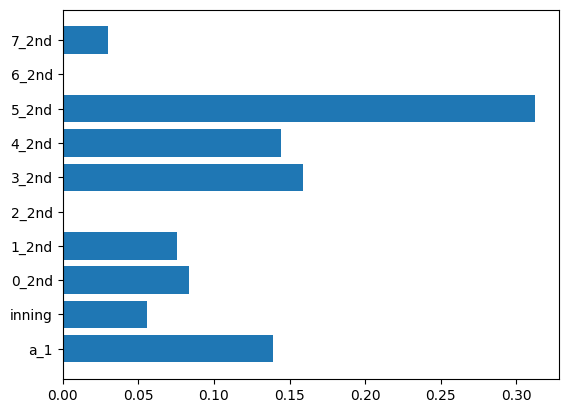

In [ ]:
plt.barh(xgb.feature_names_in_, xgb.feature_importances_)


5. 제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률을 구하시오

In [ ]:
p = 0.03
n = 25
k = 3

stats.binom.pmf(k, n, p)

0.03177384363983214

6. C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. 두 회사의 양품률에 차이가 있는지 검정하여라

In [316]:
n1 = 1000
p1 = 600 / 1000

n2 = 500
p2 = 200/ 500

d = p1 - p2
# 합동 분산
pe = (n1 * p1 + n2 * p2) / (n1 + n2)
# SE
se = np.sqrt( (pe * (1 - pe)) / n1 + (pe * (1 - pe)) / n2)

z = d/se
#p-value
p_value = 2 * (1 - stats.norm.cdf(np.abs(z)))

print(z, p_value)

7.319250547113997 2.4935609133081016e-13


In [321]:
observed = [[600, 400], [200, 300]]
chi2, p_value, dof, expected = chi2_contingency(observed)
print(chi2, p_value)

52.77087053571428 3.7481920789578267e-13


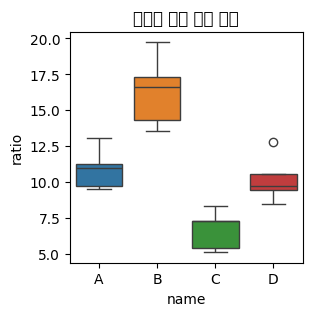

답안
데이터숫자가 적지만 정규분포와 등분산에 대한 가정을 조건으로 주었기 때문에 모수적 검정인 일원 분산분석을 통해서 그룹간 차이가 존재하는지 확인한다.
일원분산분석 p-value는 2.8174779556216382e-06로 차이가 유의하다고 볼 수 있다


In [322]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv')
plt.figure(figsize=(3,3))
sns.boxplot(x ='name', y='ratio',data =df,hue='name')
plt.title('차종별 파손 정도 비율')
plt.show()
# 일원 분산분석 수행
f_statistic, p_value = stats.f_oneway(df.query("name =='A'")['ratio'],
                                      df.query("name =='B'")['ratio'],
                                      df.query("name =='C'")['ratio'],
                                      df.query("name =='D'")['ratio'])

print('답안\n데이터숫자가 적지만 정규분포와 등분산에 대한 가정을 조건으로 주었기 때문에 모수적 검정인 일원 분산분석을 통해서 그룹간 차이가 존재하는지 확인한다.')
print(f'일원분산분석 p-value는 {p_value}로 차이가 유의하다고 볼 수 있다')

In [323]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

result = pairwise_tukeyhsd(df['ratio'], df['name'])

print(result.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B   5.3934  0.001   2.1785  8.6083   True
     A      C  -4.2156 0.0085  -7.4305 -1.0007   True
     A      D  -0.7086 0.9207  -3.9235  2.5063  False
     B      C   -9.609    0.0 -12.8239 -6.3941   True
     B      D   -6.102 0.0003  -9.3169 -2.8871   True
     C      D    3.507 0.0302   0.2921  6.7219   True
-----------------------------------------------------


L1,L2,L3 세 개의 생산라인에서 각각 13%, 37%, 50%를 생산하며 각각 1.1% , 2.1%, 3.3% 불량률을 갖는다. 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률

In [324]:
l1 = 0.13; l2 = 0.37; l3 = 0.50
ratio_l1 = 0.011; ratio_l2 = 0.021; ratio_l3 = 0.033

# 불량 제품이 나올 확률
ratio_t = ratio_l1 * l1 + ratio_l2 * l2 + ratio_l3 * l3

# 베이즈 정리를 사용하여 P(L1|불량) 계산
l1_ratio_t = (ratio_l1 * l1) / ratio_t
result = round(l1_ratio_t, 2)